In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch.utils.data.sampler import Sampler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
df = pd.read_csv(os.getcwd()+'/data/challenge_2/challenge2_dataset.csv')

In [4]:
df.head()

,Unnamed: 0,1,2,3,Target
0,0,0.60,0.31,13.0,False
1,1,0.74,0.33,21.0,False
2,2,0.54,0.19,NaN,True
3,3,0.46,NaN,9.0,False
4,4,0.77,0.15,15.0,True


In [5]:
#droping column 'unnamed: 0' and data rows with value 'NaN'
df.drop('Unnamed: 0',axis=1,inplace=True)
df.dropna(subset=['Target','1','2','3'],inplace=True)

#replace Flase with 0 and True with 1
binary_class={False:int(0),True:int(1)}
df['Target'].replace(binary_class,inplace=True)
df.head()

,1,2,3,Target
0,0.60,0.31,13.0,0
1,0.74,0.33,21.0,0
4,0.77,0.15,15.0,1
5,0.46,0.17,18.0,0
6,0.49,0.26,10.0,0


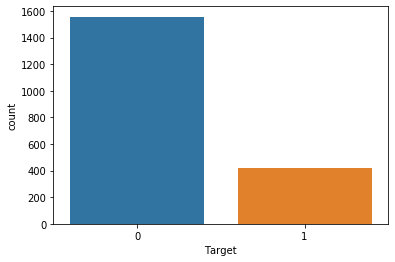

In [6]:
sns.countplot(x = 'Target', data=df)

In [7]:
'''
Our Dataset was skewed as 4/5th of the data was 'False' and only 1/5th of the data was 'True'.
trying WeightSampler: sequence of weights should correspond to your samples in the dataset

'''

print("True Positive in dataset",len(df[df['Target']==True]))
print("False Positive in dataset",len(df[df['Target']==False]))

True Positive in dataset 420
False Positive in dataset 1557


In [8]:
data = df.iloc[:, 0:-1] #column[1,2,3]
target = df.iloc[:, -1] #column[target]

train_data=df.iloc[:1500,0:-1] #X_train[1-1500]
train_target=df.iloc[:1500,-1] #y_train[1-1500]

test_data=df.iloc[1500:,0:-1] #X_test[1500-end]
test_target=df.iloc[1500:,-1] #y_test[1500-end]

In [9]:
print("Train_Features: ",train_data.shape) #3 columns
print("Train Target: ",train_target.shape)
print("Test Features: ",test_data.shape) #3 columns
print("Test Target: ",test_target.shape)

Train_Features:  (1500, 3)
Train Target:  (1500,)
Test Features:  (477, 3)
Test Target:  (477,)


In [10]:
train_data=torch.from_numpy(train_data.values).float()
test_data=torch.from_numpy(test_data.values).float()
#Datasets are ready
print(train_data.shape)
print(test_data.shape)

torch.Size([1500, 3])
torch.Size([477, 3])


In [11]:
print ('Train target train 0/1: {}/{}'.format(
    len(np.where(train_target == 0)[0]), len(np.where(train_target == 1)[0])))
print ('Test target train 0/1: {}/{}'.format(
    len(np.where(test_target == 0)[0]), len(np.where(test_target == 1)[0])))

#Number of 0s and number of 1's on each train and test

Train target train 0/1: 1170/330
Test target train 0/1: 387/90


In [12]:
train_class_sample_count = np.array(
[len(np.where(train_target == t)[0]) for t in np.unique(train_target)])

test_class_sample_count = np.array(
[len(np.where(test_target == t)[0]) for t in np.unique(test_target)])

print(train_class_sample_count)
print(test_class_sample_count)

[1170  330]
[387  90]


In [13]:
train_weight = 1./train_class_sample_count #weight for training example
train_samples_weight=np.array([train_weight[t] for t in train_target]) #append weight to numpy with respect to label

test_weight = 1. / test_class_sample_count #weight for testing example
test_samples_weight = np.array([test_weight[t] for t in test_target])#append weight to numpy with respect to label
print("Total Train Weights: ",len(train_samples_weight))
print("Total Test Weights: ",len(test_samples_weight))

Total Train Weights:  1500
Total Test Weights:  477


In [14]:
#converting numpy array to tensor
train_samples_weight = torch.from_numpy(train_samples_weight)
test_samples_weight = torch.from_numpy(test_samples_weight)
print(len(train_samples_weight),train_samples_weight.shape)
print(len(test_samples_weight),train_samples_weight.shape)


1500 torch.Size([1500])
477 torch.Size([1500])


In [15]:
#creating a weight sampler so that we can load our weights while using data loader
train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_samples_weight, len(train_samples_weight))
test_sampler = torch.utils.data.sampler.WeightedRandomSampler(test_samples_weight, len(test_samples_weight))

#converting y_train and y_test from numpy to tensor
train_target_ts=torch.from_numpy(np.array(train_target)).type(torch.FloatTensor)
test_target_ts=torch.from_numpy(np.array(test_target)).type(torch.FloatTensor)
print(len(train_target),train_target_ts.shape)
print(len(test_target),test_target_ts.shape)

1500 torch.Size([1500])
477 torch.Size([477])


In [16]:
train_dataset = torch.utils.data.TensorDataset(train_data, train_target_ts) #X_train y_train
test_dataset=torch.utils.data.TensorDataset(test_data,test_target_ts) #X_test y_test

In [17]:

#for training using device=GPU if CUDA is availabel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("Training on GPU: ",torch.cuda.get_device_name(device))


batch_size=32
learning_rate=0.001

train_loader = DataLoader(
    train_dataset, batch_size=32, num_workers=1, sampler=train_sampler)

test_loader = DataLoader(
    test_dataset, batch_size=32, num_workers=1, sampler=test_sampler)

Training on GPU:  GeForce GTX 1050 Ti


In [18]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        self.layer_1 = nn.Linear(3, 16) 
        self.layer_2 = nn.Linear(16, 8)
        self.layer_out = nn.Linear(8, 1) 
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        
        return x
    
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [19]:
model = binaryClassification()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
model=model.to(device)
model.train()
epochs = 400
epoch_loss_min=np.Inf
for e in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    if epoch_loss <= epoch_loss_min:
        print('Loss decreased ({:.6f}).  Saving model ...'.format(
        epoch_loss/len(train_loader)))
        torch.save(model.state_dict(), 'challenge_2.pt')
        epoch_loss_min = epoch_loss

Epoch 001: | Loss: 0.67202 | Acc: 51.191
Loss decreased (0.672020).  Saving model ...
Epoch 002: | Loss: 0.65148 | Acc: 49.638
Loss decreased (0.651483).  Saving model ...
Epoch 003: | Loss: 0.63917 | Acc: 51.617
Loss decreased (0.639173).  Saving model ...
Epoch 004: | Loss: 0.63594 | Acc: 61.532
Loss decreased (0.635939).  Saving model ...
Epoch 005: | Loss: 0.61517 | Acc: 67.979
Loss decreased (0.615170).  Saving model ...
Epoch 006: | Loss: 0.60131 | Acc: 76.128
Loss decreased (0.601308).  Saving model ...
Epoch 007: | Loss: 0.57445 | Acc: 78.362
Loss decreased (0.574446).  Saving model ...
Epoch 008: | Loss: 0.54636 | Acc: 80.957
Loss decreased (0.546359).  Saving model ...
Epoch 009: | Loss: 0.50956 | Acc: 82.277
Loss decreased (0.509557).  Saving model ...
Epoch 010: | Loss: 0.50275 | Acc: 83.511
Loss decreased (0.502751).  Saving model ...
Epoch 011: | Loss: 0.47508 | Acc: 85.000
Loss decreased (0.475082).  Saving model ...
Epoch 012: | Loss: 0.43906 | Acc: 85.489
Loss decrease

Epoch 169: | Loss: 0.30779 | Acc: 92.319
Epoch 170: | Loss: 0.30782 | Acc: 92.723
Epoch 171: | Loss: 0.28600 | Acc: 93.383
Epoch 172: | Loss: 0.31271 | Acc: 92.745
Epoch 173: | Loss: 0.27295 | Acc: 93.851
Epoch 174: | Loss: 0.30145 | Acc: 93.511
Epoch 175: | Loss: 0.34892 | Acc: 91.511
Epoch 176: | Loss: 0.30671 | Acc: 93.043
Epoch 177: | Loss: 0.30824 | Acc: 92.979
Epoch 178: | Loss: 0.28186 | Acc: 93.191
Epoch 179: | Loss: 0.26371 | Acc: 94.106
Epoch 180: | Loss: 0.31873 | Acc: 92.532
Epoch 181: | Loss: 0.28967 | Acc: 93.298
Epoch 182: | Loss: 0.27455 | Acc: 93.660
Epoch 183: | Loss: 0.29293 | Acc: 92.979
Epoch 184: | Loss: 0.25969 | Acc: 94.596
Loss decreased (0.259685).  Saving model ...
Epoch 185: | Loss: 0.28564 | Acc: 94.213
Epoch 186: | Loss: 0.26431 | Acc: 92.745
Epoch 187: | Loss: 0.23924 | Acc: 94.872
Loss decreased (0.239243).  Saving model ...
Epoch 188: | Loss: 0.31536 | Acc: 92.298
Epoch 189: | Loss: 0.31830 | Acc: 91.830
Epoch 190: | Loss: 0.27943 | Acc: 93.149
Epoch 19

Epoch 347: | Loss: 0.14130 | Acc: 96.298
Epoch 348: | Loss: 0.14390 | Acc: 96.468
Epoch 349: | Loss: 0.13476 | Acc: 96.660
Epoch 350: | Loss: 0.15106 | Acc: 95.383
Epoch 351: | Loss: 0.14704 | Acc: 95.851
Epoch 352: | Loss: 0.16198 | Acc: 95.447
Epoch 353: | Loss: 0.14840 | Acc: 95.787
Epoch 354: | Loss: 0.14968 | Acc: 95.702
Epoch 355: | Loss: 0.15432 | Acc: 96.149
Epoch 356: | Loss: 0.14063 | Acc: 95.809
Epoch 357: | Loss: 0.16672 | Acc: 94.872
Epoch 358: | Loss: 0.27285 | Acc: 92.383
Epoch 359: | Loss: 0.26655 | Acc: 95.340
Epoch 360: | Loss: 0.20005 | Acc: 94.213
Epoch 361: | Loss: 0.15690 | Acc: 95.234
Epoch 362: | Loss: 0.12380 | Acc: 97.191
Loss decreased (0.123803).  Saving model ...
Epoch 363: | Loss: 0.16333 | Acc: 96.021
Epoch 364: | Loss: 0.13161 | Acc: 96.979
Epoch 365: | Loss: 0.16262 | Acc: 94.702
Epoch 366: | Loss: 0.14181 | Acc: 96.213
Epoch 367: | Loss: 0.15460 | Acc: 94.957
Epoch 368: | Loss: 0.12840 | Acc: 96.149
Epoch 369: | Loss: 0.16677 | Acc: 95.021
Epoch 370: |

In [43]:
model.load_state_dict(torch.load('challenge_2.pt'))
#loading saved model

<All keys matched successfully>

In [126]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        #print(type(data))
        #print(type(target))
        data,target=data.to(device),target.to(device)
        y_test_pred = model(data)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        #print("========")
prediction=[]
for i in range(len(y_pred_list)):
    for j in range(len(y_pred_list[i])):
        for k in range(len(y_pred_list[i][j])):
            prediction.append(int(y_pred_list[i][j][k]))
target=np.array(test_target)

In [127]:
'''
Confusion Matrix
[True Positives, False Positive]
[False Negative, True Negatives]
'''

confusion_matrix(target, prediction)

array([[209, 178],
       [ 44,  46]])

In [128]:
print(classification_report(test_target, prediction))

              precision    recall  f1-score   support

           0       0.83      0.54      0.65       387
           1       0.21      0.51      0.29        90

    accuracy                           0.53       477
   macro avg       0.52      0.53      0.47       477
weighted avg       0.71      0.53      0.59       477



In [129]:
'''
Data is highly imbalanced as only 1/5th of the data looks to be True and 4/5th of the data seems to be False.

I've already tried using Logistic Regression but False Postive were more than False Negative as data was
skewed to False.

I've also tried using Neural Net with default weights initialization, result was same.

'''

"\nData is highly imbalanced as only 1/5th of the data looks to be True and 4/5th of the data seems to be False.\n\nI've already tried using Logistic Regression but False Postive were more than False Negative as data was\nskewed to False.\n\nI've also tried using Neural Net with default weights initialization, result was same.\n\n"

In [130]:
#Trying k-Nearest Neighbors 
df = pd.read_csv(os.getcwd()+'/data/challenge_2/challenge2_dataset.csv')
#droping column 'unnamed: 0' and data rows with value 'NaN'
df.drop('Unnamed: 0',axis=1,inplace=True)
df.dropna(subset=['Target','1','2','3'],inplace=True)

#replace Flase with 0 and True with 1
binary_class={False:int(0),True:int(1)}
df['Target'].replace(binary_class,inplace=True)
df.head()

,1,2,3,Target
0,0.60,0.31,13.0,0
1,0.74,0.33,21.0,0
4,0.77,0.15,15.0,1
5,0.46,0.17,18.0,0
6,0.49,0.26,10.0,0


In [131]:
scaler = StandardScaler()
scaler.fit(df.drop('Target',axis=1))
scaled_features = scaler.transform(df.drop('Target',axis=1))

In [132]:
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

,1,2,3
0,-0.040305,-0.024599,-0.078238
1,-0.034006,-0.024258,0.109705
2,-0.032656,-0.027327,-0.031253
3,-0.046605,-0.026986,0.039226
4,-0.045255,-0.025452,-0.148717


In [133]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['Target'],
                                                    test_size=0.30)

In [134]:
X_train.shape

(1383, 3)

In [135]:
knn = KNeighborsClassifier(n_neighbors=5)

In [136]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [137]:
y_pred = knn.predict(X_test)

In [138]:
'''
Confusion Matrix
[True Positives, False Positive]
[False Negative, True Negatives]
'''

print(confusion_matrix(y_test,y_pred))

[[464  10]
 [  9 111]]


In [139]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       474
           1       0.92      0.93      0.92       120

    accuracy                           0.97       594
   macro avg       0.95      0.95      0.95       594
weighted avg       0.97      0.97      0.97       594



In [140]:
submission_data=pd.read_csv(os.getcwd()+'/data/challenge_2/challenge2_prediction.csv')
submission_data.drop('Unnamed: 0',axis=1,inplace=True)
submission_data.dropna(subset=['1','2','3'],inplace=True)
submission_data.head()

,1,2,3
0,0.74,0.21,22.0
1,0.43,0.15,14.0
2,0.77,0.10,15.0
3,0.57,0.31,15.0
4,0.80,0.31,20.0


In [141]:
scaler = StandardScaler()
scaler.fit(submission_data)
scaled_features = scaler.transform(submission_data)

In [142]:
X_test=scaled_features

In [143]:
print("Features Shape: ",X_test.shape)

Features Shape:  (844, 3)


In [40]:
pred = knn.predict(X_test)

In [41]:
submission_csv=pd.DataFrame(data=pred, columns=["target"])
submission_csv.to_csv(os.getcwd()+'/data/submission/challenge_2_prediction.csv',index=False)